# EDA 

In [218]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
import scipy.stats as stats
from scipy.stats import zscore
from time import time
from tqdm import tqdm
from sklearn.impute import KNNImputer
import joblib
%matplotlib inline


Import data

In [219]:
cars = pd.read_csv('data/cars.csv', encoding = 'utf-8', encoding_errors='ignore')
cars.head()

,Unnamed: 0,name,link,price,mileage,BHP,transmission,fuel,owners,body,ULEZ,engine,year,filename,car model
0,0,Vauxhall Astra,https://www.autotrader.co.uk/car-details/20220...,£995,85405.0,103.0,Manual,Petrol,4.0,Hatchback,ULEZ,1.6L,2005 (55 reg),data\Vauxhall_Astra.txt,data\Vauxhall_Astra
1,1,Vauxhall Astra,https://www.autotrader.co.uk/car-details/20220...,"£1,350",84000.0,103.0,Manual,Petrol,3.0,Hatchback,ULEZ,1.6L,2005 (55 reg),data\Vauxhall_Astra.txt,data\Vauxhall_Astra
2,2,Vauxhall Astra,https://www.autotrader.co.uk/car-details/20220...,"£1,100",105000.0,79.0,Manual,Diesel,NaN,Estate,NaN,1.7L,2005 (54 reg),data\Vauxhall_Astra.txt,data\Vauxhall_Astra
3,3,Vauxhall Astra,https://www.autotrader.co.uk/car-details/20220...,£998,NaN,79.0,Manual,Diesel,NaN,Estate,NaN,1.7L,2005 (05 reg),data\Vauxhall_Astra.txt,data\Vauxhall_Astra
4,4,Vauxhall Astra,https://www.autotrader.co.uk/car-details/20220...,"£1,695",64000.0,123.0,Automatic,Petrol,5.0,Estate,ULEZ,1.8L,2005 (55 reg),data\Vauxhall_Astra.txt,data\Vauxhall_Astra


Drop Unnamed column

In [220]:
cols_to_drop = ['Unnamed: 0','link','filename','car model']


for col in cols_to_drop:
    cars.drop(columns = [col], inplace = True)
    
cars.head()

,name,price,mileage,BHP,transmission,fuel,owners,body,ULEZ,engine,year
0,Vauxhall Astra,£995,85405.0,103.0,Manual,Petrol,4.0,Hatchback,ULEZ,1.6L,2005 (55 reg)
1,Vauxhall Astra,"£1,350",84000.0,103.0,Manual,Petrol,3.0,Hatchback,ULEZ,1.6L,2005 (55 reg)
2,Vauxhall Astra,"£1,100",105000.0,79.0,Manual,Diesel,NaN,Estate,NaN,1.7L,2005 (54 reg)
3,Vauxhall Astra,£998,NaN,79.0,Manual,Diesel,NaN,Estate,NaN,1.7L,2005 (05 reg)
4,Vauxhall Astra,"£1,695",64000.0,123.0,Automatic,Petrol,5.0,Estate,ULEZ,1.8L,2005 (55 reg)


In [221]:
import datetime



def preprocess(df):

    # Remove commas from the "price" column
    df['price'] = df['price'].str.replace(',', '')

    # Convert the "price" column to float
    df['price'] = df['price'].str.strip('£').astype(float)

    # Remove the "L" suffix from the "engine_size" column
    df['engine'] = df['engine'].str.rstrip('L').astype(float)

    df['BHP'] = df['BHP'].round(decimals=2)

    # df.dropna(subset=['mileage','year','engine','mileage','transmission','body'], inplace=True)

    # Extract the year from the "year" column
    df['year'] = df['year'].str.extract(r'(\d{4})')

    
    df['owners'] = df['owners'].fillna(0)

    df['ULEZ'] = df['ULEZ'].apply(lambda x: 1 if x == 'ULEZ' else 0)

    # Extract car brand, model, and variant from the "name" column
    df['brand'] = df['name'].str.split(' ').str[0]
    df['model'] = df['name'].str.split(' ').str[1]

    df['model'] = df['model'].str.upper()

    df['variant'] = df['name'].str.split(' ').apply(lambda x: ' '.join(x[2:]) if len(x) > 2 else '')

    df['trim_level'] = df['variant'].str.extract('([A-Za-z]+)')

    df['trim_level'] = df['trim_level'].str.upper()

    df['trim_level'] = df['trim_level'].fillna('base')

    # Drop the original "name" and "variant" columns
    df.drop(['name', 'variant'], axis=1, inplace=True)

    return df

cars = preprocess(cars.copy())
cars.head()

,price,mileage,BHP,transmission,fuel,owners,body,ULEZ,engine,year,brand,model,trim_level
0,995.0,85405.0,103.0,Manual,Petrol,4.0,Hatchback,1,1.6,2005,Vauxhall,ASTRA,base
1,1350.0,84000.0,103.0,Manual,Petrol,3.0,Hatchback,1,1.6,2005,Vauxhall,ASTRA,base
2,1100.0,105000.0,79.0,Manual,Diesel,0.0,Estate,0,1.7,2005,Vauxhall,ASTRA,base
3,998.0,NaN,79.0,Manual,Diesel,0.0,Estate,0,1.7,2005,Vauxhall,ASTRA,base
4,1695.0,64000.0,123.0,Automatic,Petrol,5.0,Estate,1,1.8,2005,Vauxhall,ASTRA,base


In [222]:
cars['trim_level'].unique()

array(['base', 'HATCHBACK', 'SPORTS', 'C', 'DIESEL', 'X', 'I', 'GTC',
       'DOOR', 'EXCITE', 'SE', 'SRI', 'MPV', 'T', 'PLATE', 'CDTI',
       'ELECTRIC', 'E', 'TOURER'], dtype=object)

Shape

In [223]:
cars.shape

(20623, 13)

Dtypes

In [224]:
cars.dtypes

price           float64
mileage         float64
BHP             float64
transmission     object
fuel             object
owners          float64
body             object
ULEZ              int64
engine          float64
year             object
brand            object
model            object
trim_level       object
dtype: object

In [225]:
# create a dataframe of percentage of null values
null_dict = (dict(cars.isna().mean().round(4)*100))
null_df = pd.DataFrame.from_dict(null_dict, orient="index").reset_index()
null_df.columns = ['col', 'percentage']
null_df = null_df.sort_values('percentage',ascending=False)
null_df.head(10)

,col,percentage
2,BHP,63.10
9,year,1.48
8,engine,0.77
1,mileage,0.02
3,transmission,0.02
0,price,0.00
4,fuel,0.00
5,owners,0.00
6,body,0.00
7,ULEZ,0.00


Heatmap of Null Values

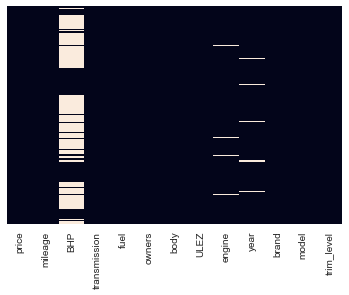

In [226]:
sns.heatmap(cars.isnull(),yticklabels=False,cbar=False)
plt.show()

### Handle Missing Values 

In [227]:
from sklearn.impute import KNNImputer

def handle_missing(df):


    df.dropna(subset=['mileage','year','engine','mileage','transmission','body'], inplace=True)

    # knn imputation
    imputer = KNNImputer(n_neighbors=5)
    df['BHP'] = imputer.fit_transform(df[['BHP']])

    current_year = datetime.datetime.now().year

    df['year'] = df['year'].astype('int')
    df['age'] = np.where(pd.notnull(df['year']), current_year - df['year'], df['year'].max())

    return df

cars = handle_missing(cars.copy())

# create a dataframe of percentage of null values
null_dict = (dict(cars.isna().mean().round(4)*100))
null_df = pd.DataFrame.from_dict(null_dict, orient="index").reset_index()
null_df.columns = ['col', 'percentage']
null_df = null_df.sort_values('percentage',ascending=False)
null_df.head(10)

,col,percentage
0,price,0.0
1,mileage,0.0
2,BHP,0.0
3,transmission,0.0
4,fuel,0.0
5,owners,0.0
6,body,0.0
7,ULEZ,0.0
8,engine,0.0
9,year,0.0


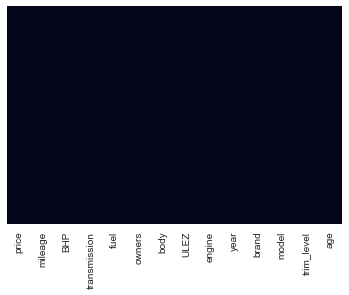

In [228]:
sns.heatmap(cars.isnull(),yticklabels=False,cbar=False)
plt.show()

In [229]:

cars.head()


,price,mileage,BHP,transmission,fuel,owners,body,ULEZ,engine,year,brand,model,trim_level,age
0,995.0,85405.0,103.0,Manual,Petrol,4.0,Hatchback,1,1.6,2005,Vauxhall,ASTRA,base,18
1,1350.0,84000.0,103.0,Manual,Petrol,3.0,Hatchback,1,1.6,2005,Vauxhall,ASTRA,base,18
2,1100.0,105000.0,79.0,Manual,Diesel,0.0,Estate,0,1.7,2005,Vauxhall,ASTRA,base,18
4,1695.0,64000.0,123.0,Automatic,Petrol,5.0,Estate,1,1.8,2005,Vauxhall,ASTRA,base,18
5,1649.0,96793.0,123.0,Automatic,Petrol,5.0,Estate,1,1.8,2005,Vauxhall,ASTRA,base,18


Mode value of BHP for each car model

In [230]:
cars.groupby(['model'])['BHP'].agg(pd.Series.mode).to_frame().reset_index()

,model,BHP
0,ASTRA,113.731258
1,CORSA,113.731258
2,GRANDLAND,113.731258
3,GTC,113.731258
4,MERIVA,99.000000
5,MOKKA,113.731258
6,NON-FRANCHISE,113.731258
7,ZAFIRA,113.731258


### Remove Rows

### Remove unwanted characters from Values

Changing Datatypes

In [231]:

cars.dtypes

price           float64
mileage         float64
BHP             float64
transmission     object
fuel             object
owners          float64
body             object
ULEZ              int64
engine          float64
year              int32
brand            object
model            object
trim_level       object
age               int32
dtype: object

In [232]:
# Select only the continuous features from the dataset
cont_features = cars.select_dtypes(include=['float', 'int']).columns.to_list()
cat_features = cars.select_dtypes(include=['object']).columns.to_list()


In [233]:
cars.isnull().sum()

price           0
mileage         0
BHP             0
transmission    0
fuel            0
owners          0
body            0
ULEZ            0
engine          0
year            0
brand           0
model           0
trim_level      0
age             0
dtype: int64

### Costliest Car

In [234]:
highest_cost = cars[['model','trim_level','mileage','price']].sort_values('price',ascending=False).head(10)
highest_cost.head()

,model,trim_level,mileage,price
14692,GRANDLAND,X,1148.0,30000.0
14679,GRANDLAND,X,10.0,29990.0
14617,GRANDLAND,X,18577.0,28999.0
14611,GRANDLAND,X,8154.0,28991.0
14583,GRANDLAND,X,14981.0,28922.0


In [235]:
cheapest_car = cars[['model','trim_level','mileage','price']].sort_values('price',ascending=True).head(10)
cheapest_car.head()

,model,trim_level,mileage,price
14740,MERIVA,base,129757.0,495.0
6996,CORSA,base,188000.0,500.0
14719,MERIVA,base,98787.0,600.0
452,ASTRA,base,108933.0,600.0
5897,CORSA,base,97600.0,600.0


Function to plot barchart

In [236]:
def plot_bar_chart(df,x_col,y_col,title='',figsize=(10,5),palette='magma'):
        """
        function to plot charts 
        i/p : df,x_col,y_col 
        o/p : saves file in local directory
        
        """



        plt.figure(figsize = figsize) # setting the size of the output


        sns.barplot( data = df,
                        x = x_col,
                        y = y_col,
                        palette = palette # setting the colours
                )

        # We can also adjust the labels
        plt.xticks(rotation=45, # rotating labels
                horizontalalignment = 'right', # aligning them with the bars
                fontweight = 'light',
                fontsize = 'large' # setting the fonts
                )

        plt.title(title) # naming the plot

        plt.savefig('plot.png', dpi = 300, bbox_inches = 'tight') # saving the chart as a .png – it will be saved in the current working directory

        plt.show()


def plot_scatter_chart(df,x_col,y_col,title='',figsize=(10,5)):
        """
        function to plot charts 
        i/p : df,x_col,y_col 
        o/p : saves file in local directory
        
        """



        plt.figure(figsize = figsize) # setting the size of the output

        sns.set_style("whitegrid")
        sns.barplot( data = df,
                        x = x_col,
                        y = y_col,
                        palette = 'magma' # setting the colours
                )

        # We can also adjust the labels
        plt.xticks(rotation=45, # rotating labels
                horizontalalignment = 'right', # aligning them with the bars
                fontweight = 'light',
                fontsize = 'large' # setting the fonts
                )

        plt.title(title) # naming the plot

        plt.savefig('plot.png', dpi = 300, bbox_inches = 'tight') # saving the chart as a .png – it will be saved in the current working directory

        plt.show()

In [237]:
car_models = ['Corsa','Grandland']
cars_filtered = cars[cars['model'].isin(car_models)]
cars_filtered.model.unique()

array([], dtype=object)

Car Count by name

In [238]:
car_count = cars.groupby('model')[['model']].count()
car_count = car_count.rename(columns = {'model':'car_count'})
car_count = car_count.sort_values(by='car_count',ascending=False)
car_count.reset_index(inplace=True)
car_count.head()

,model,car_count
0,CORSA,7231
1,ASTRA,5687
2,MOKKA,3843
3,GRANDLAND,1443
4,ZAFIRA,1367


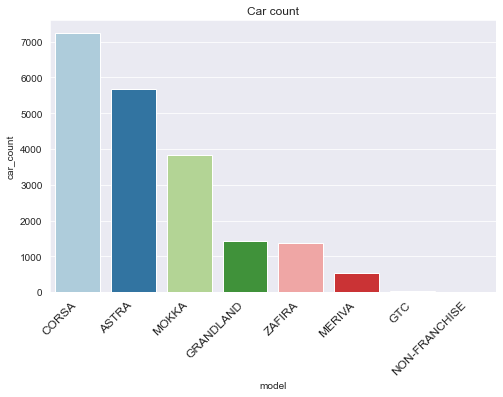

In [239]:
plot_bar_chart(car_count,'model','car_count',
                title='Car count',
                figsize=(8,5),
                palette='Paired')

Car type Max prices

In [240]:
cars_max_price = cars.groupby('model')['price'].max().reset_index()
cars_max_price = cars_max_price.sort_values(by='price',ascending=False)
cars_max_price

,model,price
2,GRANDLAND,30000.0
5,MOKKA,28875.0
1,CORSA,23550.0
3,GTC,23000.0
6,NON-FRANCHISE,22790.0
0,ASTRA,21495.0
7,ZAFIRA,19395.0
4,MERIVA,11099.0


Car type Max owners

In [241]:
cars_max_owners = cars.groupby('model')['owners'].mean().reset_index()
cars_max_owners = cars_max_owners.sort_values(by='owners',ascending=False)
cars_max_owners


,model,owners
4,MERIVA,1.741935
7,ZAFIRA,1.391368
0,ASTRA,1.214700
1,CORSA,0.993362
5,MOKKA,0.662763
3,GTC,0.468085
2,GRANDLAND,0.270270
6,NON-FRANCHISE,0.000000


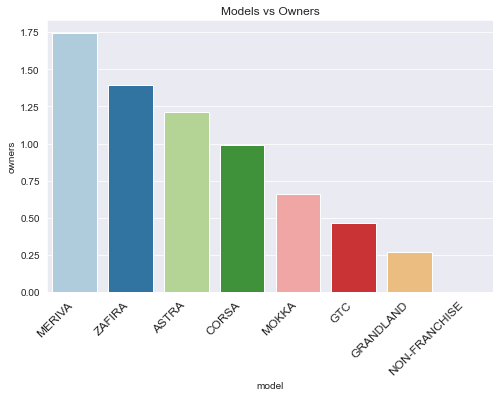

In [242]:
plot_bar_chart(cars_max_owners,
                'model','owners',
                title='Models vs Owners',
                figsize=(8,5),
                palette='Paired')

Fuel type  vs Price

In [243]:
fuel_type = cars.groupby('fuel')['price'].mean().reset_index()
fuel_type = fuel_type.sort_values(by='price',ascending=False)
fuel_type.head()

,fuel,price
2,Petrol Plug-in Hybrid,27464.129032
1,Petrol,9472.579751
0,Diesel,8356.604219


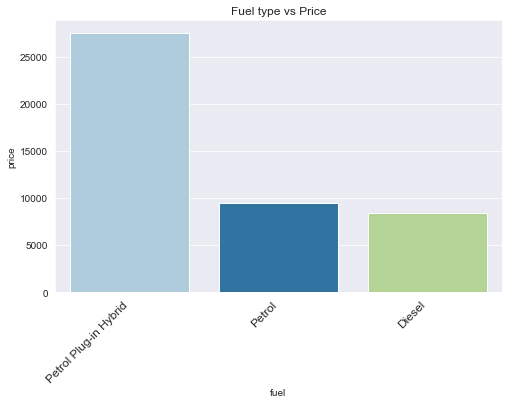

In [244]:
plot_bar_chart(fuel_type,'fuel','price',
                title='Fuel type vs Price',
                figsize=(8,5),
                palette='Paired')

Transmission vs Price

In [245]:
transmission = cars.groupby(['transmission'])['price'].mean().reset_index()
transmission

,transmission,price
0,Automatic,11545.978334
1,Manual,8918.126716


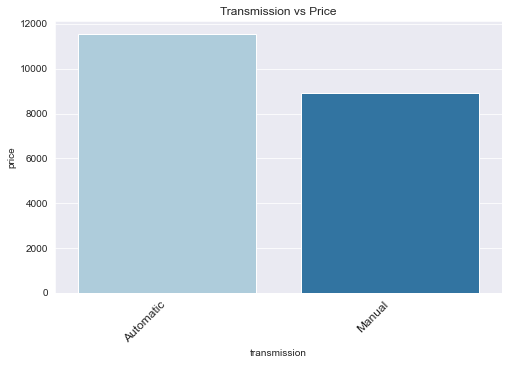

In [246]:
plot_bar_chart(transmission,'transmission','price',
                title='Transmission vs Price',
                figsize=(8,5),
                palette='Paired')

Transmission vs Price

<AxesSubplot:xlabel='year', ylabel='price'>

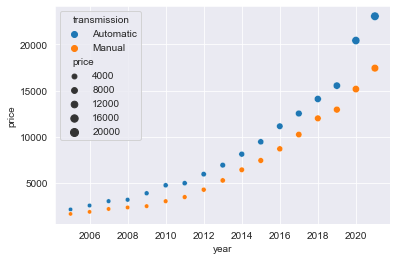

In [247]:
transmission_yearly_price = cars.groupby(['transmission','year'])['price'].mean().reset_index()
sns.set_style("darkgrid")
sns.scatterplot(data = transmission_yearly_price, x = 'year', y = "price", hue = "transmission",size='price')

ULEZ vs price

In [248]:
ulez_price = cars.groupby(['ULEZ','year'])['price'].mean().reset_index()
ulez_price.head()

,ULEZ,year,price
0,0,2005,1554.583333
1,0,2006,1837.666667
2,0,2007,1968.341463
3,0,2008,2184.900000
4,0,2009,2413.631579


<AxesSubplot:xlabel='year', ylabel='price'>

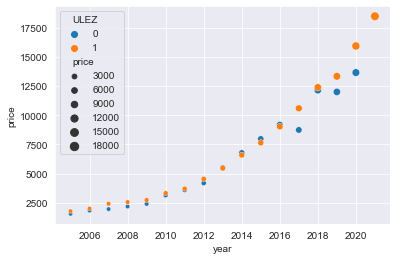

In [249]:
sns.scatterplot(data = ulez_price, x = 'year', y = "price", hue = "ULEZ",size='price')

In [250]:
cars['ULEZ'].value_counts().reset_index()

,index,ULEZ
0,1,18435
1,0,1715


Car Engine vs Price

In [251]:
# car engine vs price for corsa and grandland x
cars_engine_price = cars_filtered.groupby(['model','engine'])['price'].mean().reset_index()
cars_engine_price

,model,engine,price


<AxesSubplot:>

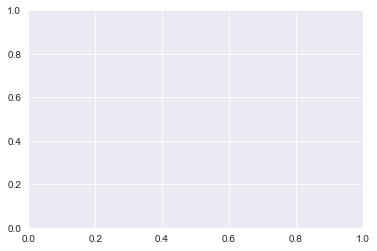

In [252]:
sns.lineplot(data = cars_engine_price, x = 'engine', y = "price", hue = "model")

Save data

In [253]:
cars.describe()

,price,mileage,BHP,owners,ULEZ,engine,year,age
count,20150.000000,20150.000000,20150.000000,20150.000000,20150.000000,20150.000000,20150.000000,20150.000000
mean,9303.371067,46092.993697,113.731258,0.986104,0.914888,1.436749,2015.533499,7.466501
std,4770.099457,31463.985855,20.166005,1.481772,0.279055,0.203408,3.553096,3.553096
min,495.000000,10.000000,59.000000,0.000000,0.000000,1.000000,2005.000000,2.000000
25%,5495.000000,20700.750000,113.731258,0.000000,1.000000,1.400000,2013.000000,5.000000
50%,9094.000000,39416.000000,113.731258,0.000000,1.000000,1.400000,2016.000000,7.000000
75%,12691.750000,66020.000000,113.731258,2.000000,1.000000,1.600000,2018.000000,10.000000
max,30000.000000,256173.000000,298.000000,15.000000,1.000000,2.200000,2021.000000,18.000000


### Plot Correlation

In [254]:
def plot_correlation(corr):



    plt.figure(figsize = (6,6)) # setting the size of the output

    sns.heatmap(corr,
                annot = True,
                linecolor='black',
                center=0,
                vmin=-1,
                vmax=1,
                cmap = sns.diverging_palette(600,600, as_cmap=True),
                fmt='.4g')

    plt.title('Car features and thier correlation') # naming the plot

    #plt.savefig('plot.png', dpi = 300, bbox_inches = 'tight') # saving the chart as a .png – it will be saved in the current working directory

    plt.show()

In [255]:
cars_corr = cars.corr()
cars_corr

,price,mileage,BHP,owners,ULEZ,engine,year,age
price,1.000000,-0.774262,0.183995,-0.395360,0.261672,-0.266040,0.853600,-0.853600
mileage,-0.774262,1.000000,-0.031726,0.361480,-0.332612,0.348438,-0.734111,0.734111
BHP,0.183995,-0.031726,1.000000,-0.006539,-0.072612,0.490052,0.091291,-0.091291
owners,-0.395360,0.361480,-0.006539,1.000000,-0.122646,0.154206,-0.405777,0.405777
ULEZ,0.261672,-0.332612,-0.072612,-0.122646,1.000000,-0.485073,0.271498,-0.271498
engine,-0.266040,0.348438,0.490052,0.154206,-0.485073,1.000000,-0.327427,0.327427
year,0.853600,-0.734111,0.091291,-0.405777,0.271498,-0.327427,1.000000,-1.000000
age,-0.853600,0.734111,-0.091291,0.405777,-0.271498,0.327427,-1.000000,1.000000


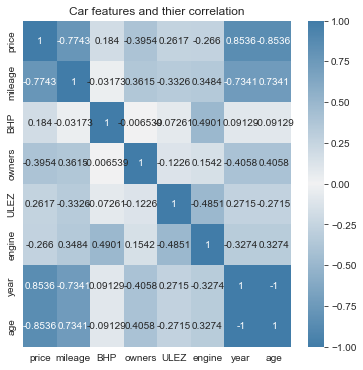

In [256]:
plot_correlation(cars_corr)

As per the above matrix, 
<li>it looks like the 'price' variable is strongly positively correlated with 'year' variable (0.83)</li> 
<li>and moderately positively correlated with 'BHP' variable (0.44) </li>
<li>and 'mileage' variable is strongly negatively correlated with the 'year' variable (-0.63) and moderately negatively correlated with the 'price' variable (-0.73).</li>

Pairplot

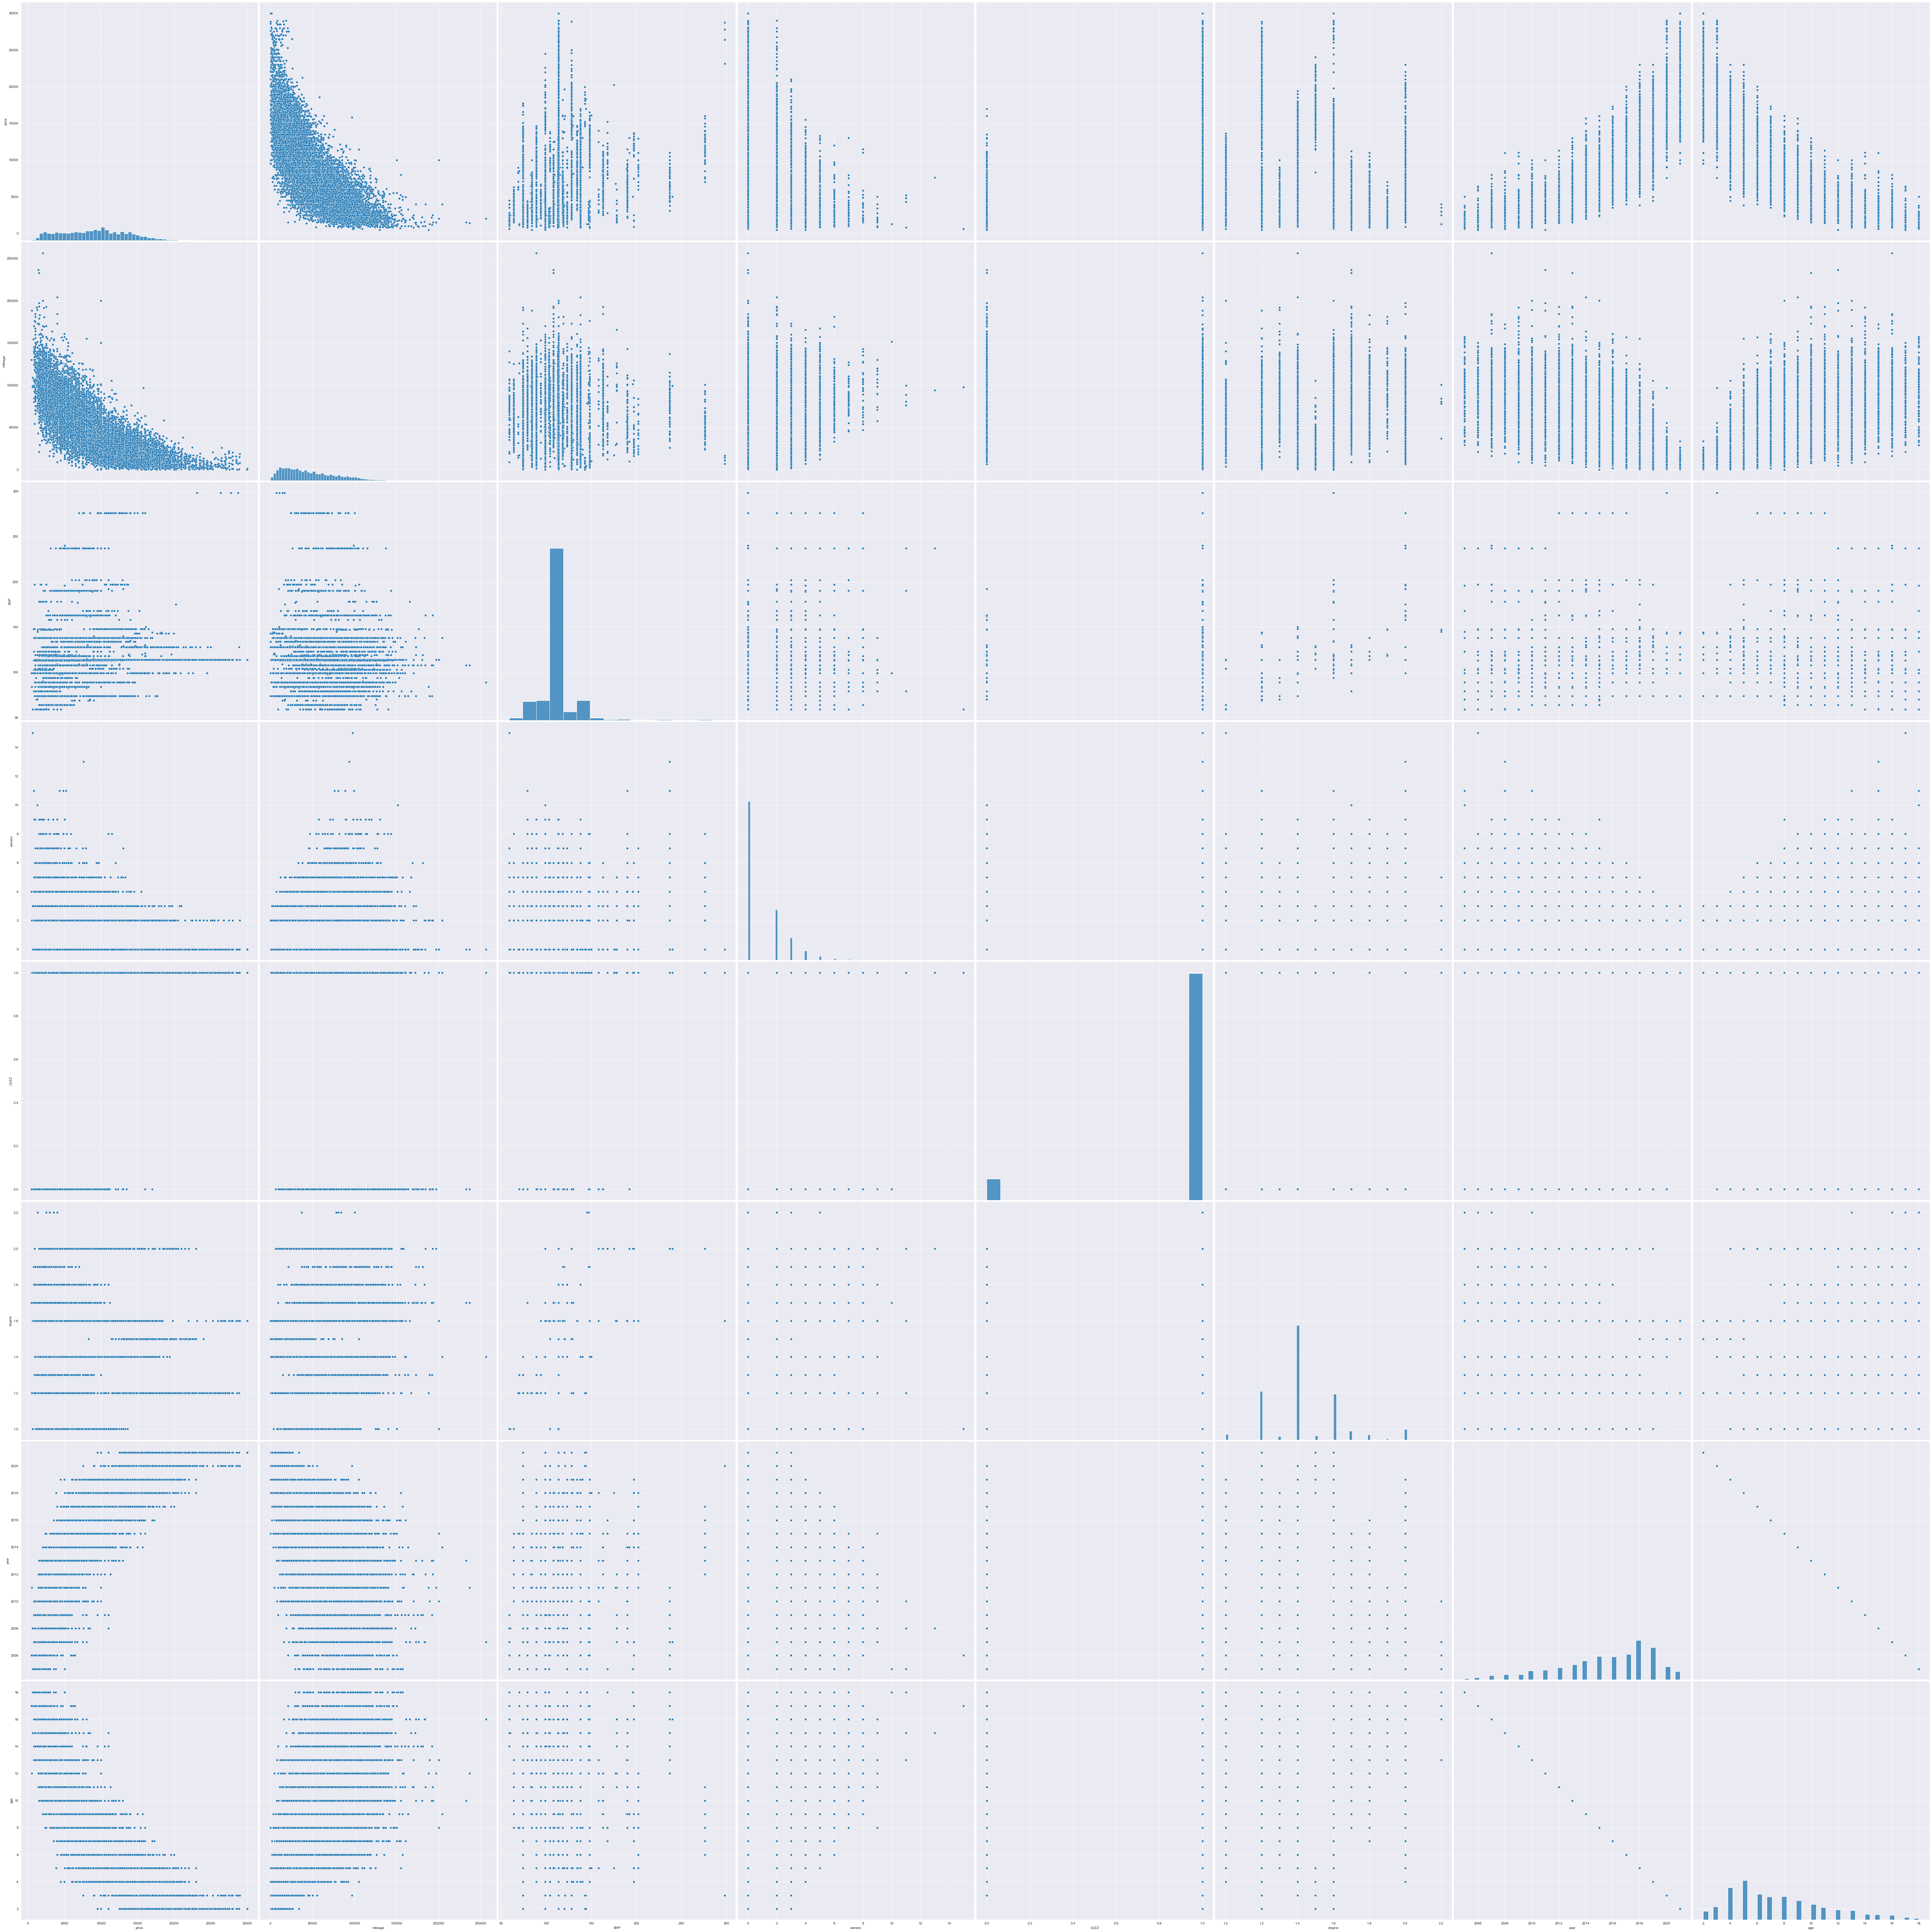

In [257]:
sns.pairplot(cars, height = 10)
plt.show()

In [258]:
cars.isnull().sum()

price           0
mileage         0
BHP             0
transmission    0
fuel            0
owners          0
body            0
ULEZ            0
engine          0
year            0
brand           0
model           0
trim_level      0
age             0
dtype: int64

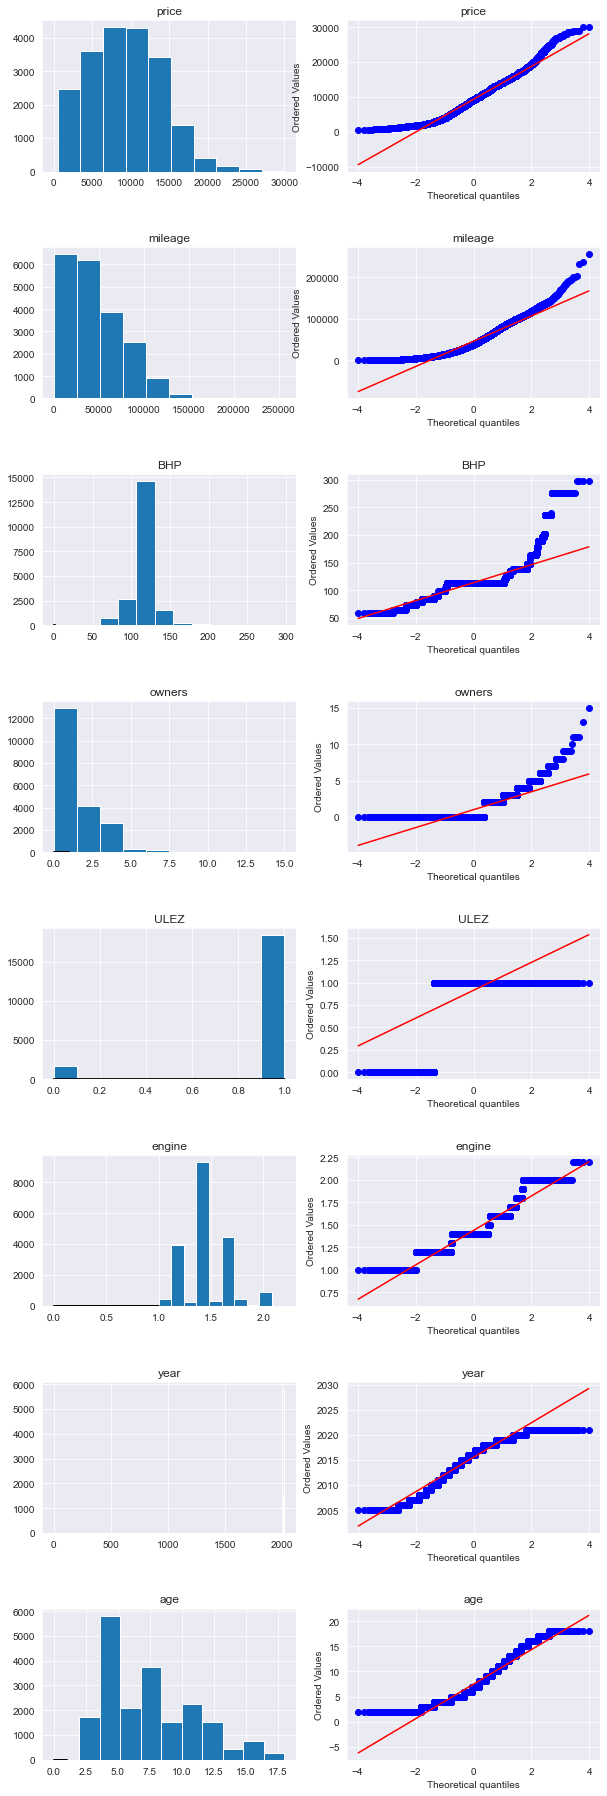

In [259]:




def check_normality(df):

    df=df[cont_features]
    num_columns=len(cont_features)
    # Create a figure with a subplot for each feature
    fig, axes = plt.subplots(num_columns, 2, figsize=(10, num_columns*4))
    fig.subplots_adjust(hspace=0.5)

    # Plot a histogram and normal quantile plot for each feature
    for i in range(num_columns):
        feature = df.columns[i]

        # Plot a histogram of the feature
        axes[i, 0].hist(df[feature])

        # Overlay a normal distribution on the histogram
        mu, std = stats.norm.fit(df[feature])
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = stats.norm.pdf(x, mu, std)
        axes[i, 0].plot(x, p, 'k', linewidth=2)
        axes[i, 0].set_title(feature)

        # Create a normal quantile plot of the feature
        stats.probplot(df[feature], plot=axes[i, 1])
        axes[i, 1].set_title(feature)

    plt.show()

check_normality(cars)

Outlier

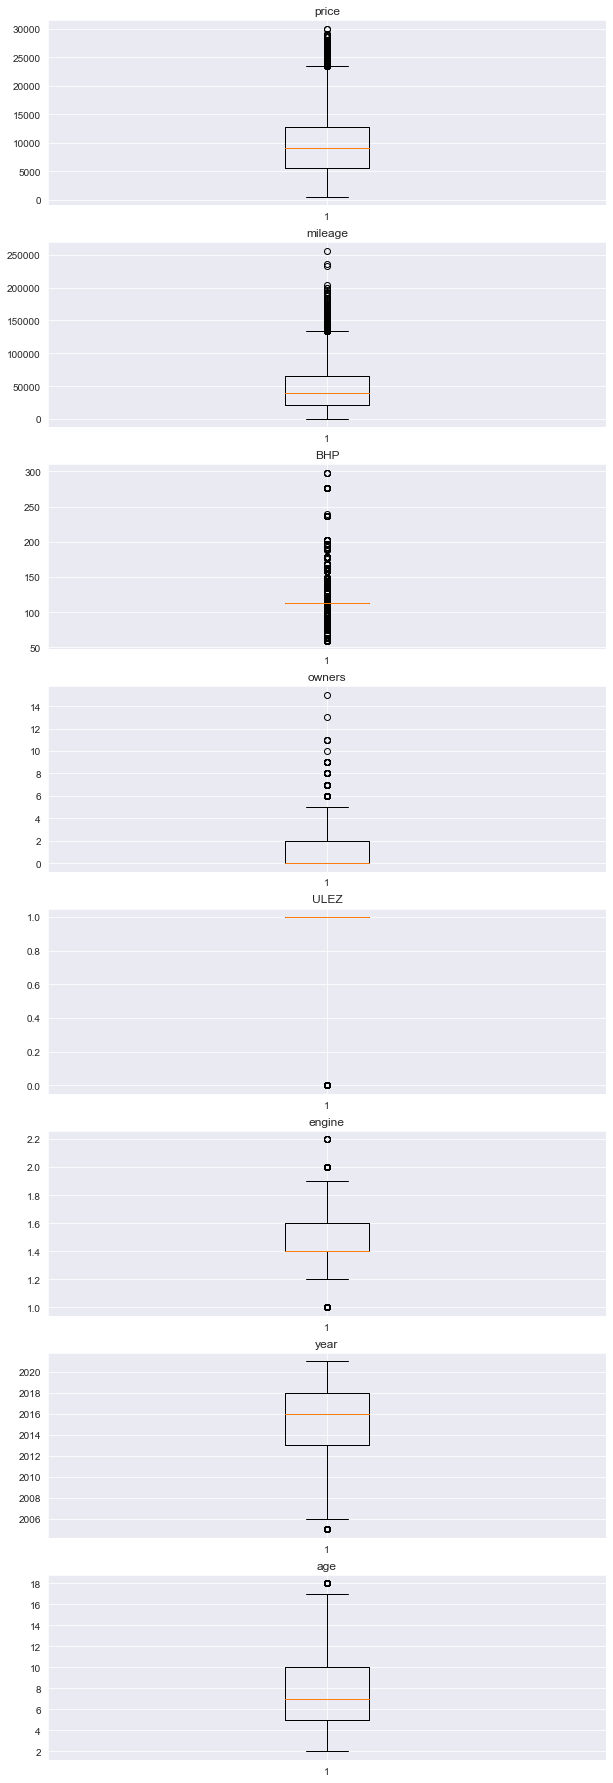

In [260]:

def plot_outlier_plot(df):

    # Get the number of continuous features
    num_features = len(cont_features)

    # Create a figure with a subplot for each feature
    fig, axes = plt.subplots(num_features, 1, figsize=(10, num_features*4))
    cont_df=df[cont_features]
    # Create a boxplot for each feature
    for i,feature in enumerate(cont_features):
        feature = cont_df.columns[i]
        axes[i].boxplot(cont_df[feature])
        axes[i].set_title(feature)

    plt.show()

plot_outlier_plot(cars)

### Remove Outliers

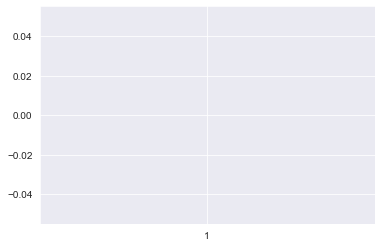

In [264]:
import helper

outlier_cols = ['price','mileage']

cars = helper.remove_outliers(cars,outlier_cols)
plt.boxplot(cars['price'])
plt.show()


In [265]:
cars.head()

,price,mileage,BHP,transmission,fuel,owners,body,ULEZ,engine,year,brand,model,trim_level,age
0,995.0,85405.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1350.0,84000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1100.0,105000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1695.0,64000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1649.0,96793.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [262]:
cars.to_csv('data/cars_cleaned.csv',index=False)



,price,mileage,BHP,transmission,fuel,owners,body,ULEZ,engine,year,brand,model,trim_level,age
0,995.0,85405.0,103.0,Manual,Petrol,4.0,Hatchback,1,1.6,2005,Vauxhall,ASTRA,base,18
1,1350.0,84000.0,103.0,Manual,Petrol,3.0,Hatchback,1,1.6,2005,Vauxhall,ASTRA,base,18
2,1100.0,105000.0,79.0,Manual,Diesel,0.0,Estate,0,1.7,2005,Vauxhall,ASTRA,base,18
4,1695.0,64000.0,123.0,Automatic,Petrol,5.0,Estate,1,1.8,2005,Vauxhall,ASTRA,base,18
5,1649.0,96793.0,123.0,Automatic,Petrol,5.0,Estate,1,1.8,2005,Vauxhall,ASTRA,base,18


In [263]:
cars.describe()

,price,mileage,BHP,owners,ULEZ,engine,year,age
count,20005.000000,20005.000000,20005.000000,20005.000000,20005.000000,20005.000000,20005.000000,20005.000000
mean,9184.706823,46377.111072,113.700794,0.991452,0.914271,1.437831,2015.495476,7.504524
std,4576.231480,31396.301908,20.111206,1.484734,0.279970,0.203261,3.537491,3.537491
min,495.000000,10.000000,59.000000,0.000000,0.000000,1.000000,2005.000000,2.000000
25%,5495.000000,21000.000000,113.731258,0.000000,1.000000,1.400000,2013.000000,5.000000
50%,9000.000000,39859.000000,113.731258,0.000000,1.000000,1.400000,2016.000000,7.000000
75%,12549.000000,66500.000000,113.731258,2.000000,1.000000,1.600000,2018.000000,10.000000
max,23481.000000,256173.000000,298.000000,15.000000,1.000000,2.200000,2021.000000,18.000000
